# One Factor Hull-White model in PyTorch
Thomas Viehmann, <tv@interestingrates.de>

In this notebook, we are implementing the [Hull-White model](https://en.wikipedia.org/wiki/Hull-White_model) in the formulation given by Brigo and Mercurio [On Deterministic Shift Extensions of Short Rate Models](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=292060) in PyTorch.

Thus we implement three things:
- A special case of the one-factor Vasicek model including pricing of zero-coupon bond options.
- The shift extension from this Vasicek model to the Hull-White-Model.
- Swaption pricing using [Jamshidian's decomposition](https://en.wikipedia.org/wiki/Jamshidian's_trick) in the one-factor model

The last two parts can be shared between the Hull-White model and the CIR++ proposed by Brigo and Mercurio (though there are minute differences to the [CIR notebook's version](CIR.ipynb)).

And we would like many things, in particular swaption prices, to be differentiable by the model parameters in order to do calibration.
The Hull-White model is given by the stochastic differential equation
$$
dr_t = \alpha (\mu(t)-r_t) dt + \sigma dW_t.
$$
It has a closed-form solution for $r_t$: The short rate $r_t$ is normally distributed with
$$
r_t \sim \mathcal{N}\left(\exp(-\alpha t) r_0 + \int_0^t \exp(-\alpha (t-s)) \mu(t) ds, \frac{\sigma^2}{2\alpha} (1-\exp(-2\alpha t))\right).
$$

Brio and Mercurio point out that $\mu(t)$ and the initial value $r_0$ only affect the mean value of $r_t$, but not the stochasticity around it.
Thus, one can write the model as a mean-zero Vasicek model
$$
dr^{\text{V0}}_t = - \alpha r^{\text{V0}}_t dt + \sigma dW_t,
$$
shifted by
$$
r^{\text{shifted}}(t) = r^{\text{V0}}(t) + \varphi(t)
$$
for the deterministic shift function $\varphi = E(r_t)$.

As we are interested in observations of fixed time intervals and a corresponding set of discrete maturities, where only integrals of $\varphi$ between time steps play a rôle, or more precisely, factors $F(t,T)=\exp(-\int_t^T \varphi d\tau)$. But these can be expressed as quotients
$$
\exp\left(-\int_t^T \varphi d\tau\right)=\frac{ZCB(t,T)}{ZCB^{\text{V0}}(t,T)}.
$$
Indeed, we will not compute or work with $\varphi$ and substitute the above when applying Brigo or Mercurio's formulas (the same formulas as in the article mentioned above also appear in their book).

First we import a few python modules.

In [1]:
import torch
import numpy
from matplotlib import pyplot
import jupyter_import
%matplotlib inline

We introduce a convenience function to wrap scalars and tensors in autograd `Variables`.

In [2]:
%lib
def wrap(x, **argv):
  if numpy.isscalar(x):
    x = torch.autograd.Variable(torch.DoubleTensor([x]), **argv)
  elif isinstance(x, torch.DoubleTensor):
    x = torch.autograd.Variable(x)
  elif isinstance(x, torch.FloatTensor):
    x = torch.autograd.Variable(x.double())
  elif isinstance(x, (torch.autograd.Variable, torch.nn.Parameter)):
    pass
  else:
    raise Exception("Nothing to help you with "+str(x))
  return x


We use an [approximation from Wikipedia](https://en.wikipedia.org/wiki/Normal_distribution#Numerical_approximations_for_the_normal_CDF) for the Normal CDF.

In [3]:
a_for_erf = 8.0/(3.0*numpy.pi)*(numpy.pi-3.0)/(4.0-numpy.pi)
def erf_approx(x):
    return torch.sign(x)*torch.sqrt(1-torch.exp(-x*x*(4/numpy.pi+a_for_erf*x*x)/(1+a_for_erf*x*x)))
def erfinv_approx(x):
    b = -2/(numpy.pi*a_for_erf)-torch.log(1-x*x)/2
    return torch.sign(x)*torch.sqrt(b+torch.sqrt(b*b-torch.log(1-x*x)/a_for_erf))

def normal_cdf(x):
    return 0.5*(1.0+erf_approx(x/(2**0.5)))


For the Jamshidian decomposition we need an implicitly defined critical rate $r^*$. This will be obtained by
gradient descent to minimize the square norm of the defining function to find the zero level set, i.e.
$f(x) = y$ where $y$ is given by $F(x,y)=0$.

The implicit function theorem readily provides a formula for the derivative, in order to backpropagate through
the implicit function, we define an autograd function. Details of the implementation and a brief mention of
mathematics is at my [Implicit functions in Pytorch Notebook](https://github.com/t-vi/pytorch-tvmisc/blob/master/misc/Implicit_Functions_Pytorch.ipynb). Note that the input may $x$ may be a vector, but the sought value $y$ needs to be a scalar as we do not compute the Jacobian and its inverse. But that is all we need.

In [4]:
%lib
class Implicit(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, y0, F, max_iter=200, reg=1e-6):
        y = torch.autograd.Variable(y0.clone(), requires_grad=True)
        xv = torch.autograd.Variable(x)
        opt = torch.optim.LBFGS([y], max_iter=max_iter)
        def reevaluate():
            opt.zero_grad()
            z = F(xv,y)**2
            z.backward()
            return z
        opt.step(reevaluate)
        xv = torch.autograd.Variable(x, requires_grad=True)
        y.grad = None
        z = F(xv,y)
        z.backward()
        ctx._dx_by_dy = xv.grad.data/(y.grad.data+y.grad.data.sign()*reg)
        return y.data
    @staticmethod
    def backward(ctx, output_grad):
        return -torch.autograd.Variable(ctx._dx_by_dy)*output_grad, None, None, None, None

We are now ready to define a Vasicek0 class.
While the bond price and zero-coupon bond option formulas seem to be well-covered in the literature (e.g. Brigo and Mercurio), the simulation implemented in the `step` method below seems to be less so. For your convenience, I have written some [notes on the derivation](http://www.interestingrates.de/artikel/hull-white-implementation/).

In [5]:
%lib
eps = 1e-8

class Vasicek0:
    def __init__(self, alpha, sigma):
        self.alpha = alpha
        self.sigma = sigma
        self.initr = wrap(0.0)
    def get_params(self):
        return torch.cat([self.alpha, self.sigma])
    def step(self, dt, r0, defl0):
        numSim = r0.size(0)
        
        mu = torch.exp(-self.alpha*dt)
        VR  = ((self.sigma**2/(2*self.alpha))*(1-mu**2))
        VIntR  = (self.sigma**2/(self.alpha**3) * ( dt*self.alpha - 2*(1-mu) + (1-mu**2)/2))
        CovRIntR     = (self.sigma**2/(2*self.alpha**2)) * ((1-mu)**2)# ((1-mu)**2)
        rnd2factor   = (VIntR - CovRIntR**2/VR)**0.5
        rnd = r0.data.new(*r0.size()).normal_()
        numRnd = r0.size(0)//2
        rnd1 = wrap(torch.cat((rnd[:numRnd],-rnd[:numRnd]),dim=0))
        rnd2 = wrap(torch.cat((rnd[numRnd:],-rnd[numRnd:]),dim=0))
        r = r0*mu + VR**0.5 * rnd1
        defl = defl0 * torch.exp(-(r0/self.alpha*(1-mu)+ (CovRIntR/(VR**0.5))*rnd1+ rnd2factor*rnd2))
        
        return r, defl

    def simulate(self, num_sims, num_years, initr=None, steps_per_year=1):
        """Simulate the process for a given number of years and simulations and keep the annual values"""
        initr = initr if initr is not None else wrap(0.0)
        r0 = initr.expand(num_sims)
        d0 = wrap(torch.ones(num_sims))
        r = [r0]
        d = [d0]
        for i in range(num_years):
            for j in range(steps_per_year):
                r0,d0 = model.step(1.0/steps_per_year,r0,d0)
            r.append(r0)
            d.append(d0)
        r = torch.stack(r)
        d = torch.stack(d)
        return r,d

    def zcb_price(self, r, term, params=None):
        """Returns ZCB prices (= expected exponential integrated short rates) in the Vasicek 0 model"""
        if params is None:
            alpha, sigma = self.alpha, self.sigma
        else:
            alpha, sigma = torch.split(params, 1, dim=0)
        B = (1-torch.exp(-alpha*term))/alpha
        A = torch.exp(-sigma**2/(2*alpha**2)*(B-term)-sigma**2/(4*alpha)*B**2)
        return A*torch.exp(-B*r)

    def init_zcb_price(self, term):
        """Return initial ZCB prices, a convenience function for the shift extension"""
        return self.zcb_price(0.0, term)
        
    def call_zcb(self, term, tenor, X, r0):
        """Returns the price of a call option on a zero coupon bond.
        The option matures at term, the zero coupon bond at term+tenor.
        The strike ZCB price is X.
        The current (time 0) short rate is r0."""

        sigma_zcb = 1/self.alpha*(1-torch.exp(-self.alpha*(tenor)))*torch.sqrt(self.sigma**2/(2*self.alpha)*(1-torch.exp(-2*self.alpha*term)))
        Pbondmat = self.zcb_price(r0, term+tenor)
        Poptionexp = self.zcb_price(r0, term)
        d1 = (Pbondmat.log()-Poptionexp.log()-X.log()+0.5*sigma_zcb**2)/(sigma_zcb)
        d2 = d1-sigma_zcb
        return Pbondmat*normal_cdf(d1)-Poptionexp*X*normal_cdf(d2)


We are now ready to implement the shifted model of Brigo and Mercurio that will give a Hull-White-Model when combined with the above.

We take a fully initialized `Vasicek0` model (that can give zero bond prices) and a desired Zero Coupon Bond curve.
The formulas follow Brigo and Mercurio with the substitution mentioned above and get formulas for the deflators (in the method `simulate`), zero coupon bonds (but this time, it is dependend on the time step, so we expect $r$ to be of shape $timesteps \times simulation$).

The function `call_atm_swap` implements pricing of at the money european receiver swaptions using Jamshidians decomposition. The critical rate $r^*$ is defined as the one where the resulting swap rate is exactly the strike swap rate. Using that the forward swap rate $s$ is defined as 
$$f = \frac{ZCB(0,oterm)-ZCB(0,oterm+tenor)}{\sum_{i=oterm+1}^{oterm+tenor}ZCB(0,i)},$$
we can define the critical rate $r^*$ as the rate given by the equation
$$
F(\alpha,\mu,\sigma,r^*):=s_{\text{strike}} \sum_{i=oterm+1}^{oterm+tenor}ZCB(0,i) - (ZCB(0,oterm)-ZCB(0,oterm+tenor)) =0.
$$
The ZCB prices and thus the critical rate also depend on the model parameters $\alpha$, $\mu$, and $\sigma$.

In [6]:
%lib
class ShiftedModel:
  def __init__(self, basemodel, zcbs):
    self.zcbs  = zcbs
    self.basemodel = basemodel
    self.xzcbsbase = self.basemodel.init_zcb_price(wrap(torch.arange(0,zcbs.size(0)+1)))
    self.zcbsbase = self.xzcbsbase[1:]
    self.xzcbs = torch.cat((wrap(self.zcbs.data.new(1).fill_(1.0)),self.zcbs),dim=0)

  def simulate(self, num_sims, num_years, steps_per_year=12):
    r, d_base = self.basemodel.simulate(num_sims, num_years, steps_per_year=steps_per_year)
    numYears_plus_one = r.size(0)
    d = d_base*(self.xzcbs[:numYears_plus_one].unsqueeze(1)/self.xzcbsbase[:numYears_plus_one].unsqueeze(1))
    return r,d

  def zcb_price(self, r, term):
    numYears = r.size(0)-1
    assert len(self.zcbs)>=term+numYears
    forwardzcbs = self.xzcbs[term:]/self.xzcbs[:-term]
    forwardzcbsbase = self.xzcbsbase[term:]/self.xzcbsbase[:-term]
    forwardzcbfactors = forwardzcbs[:numYears+1]/forwardzcbsbase[:numYears+1]
    zcbPrice = self.basemodel.zcb_price(r, term)*forwardzcbfactors.unsqueeze(1)
    return zcbPrice

  def forward_zcb_prices_terms(self, r, t, maxterm, params=None):
    assert len(self.xzcbs) >= t+maxterm+1
    terms = wrap(torch.arange(0, maxterm+1))
    zcb_prices_base = self.basemodel.zcb_price(r, terms, params=params)
    forwardzcbsbase = zcb_prices_base/zcb_prices_base[0] #self.xzcbsbase[t:t+maxterm+1]/self.xzcbsbase[t]
    forwardzcbs = self.xzcbs[t:t+maxterm+1]/self.xzcbs[t]
    forwardzcbfactors = forwardzcbs/forwardzcbsbase
    zcbPrices = zcb_prices_base*forwardzcbfactors
    return zcbPrices
    
  def call_zcb(self, term, tenor, X, r0): # Brigo Mercurio ZCB in CIR
    zcb_factor_term_plus_tenor = self.xzcbs[term+tenor]/self.xzcbsbase[term+tenor]
    zcb_factor_term = self.xzcbs[term]/self.xzcbsbase[term]
    X_adj = X/(zcb_factor_term_plus_tenor/zcb_factor_term)
    return self.basemodel.call_zcb(term, tenor, X_adj, r0)*zcb_factor_term_plus_tenor

  def call_atm_swap(self, oterm, tenor, r0=None):
    if r0 is None:
        r0 = self.basemodel.initr
    s = (self.xzcbs[oterm]-self.xzcbs[oterm+tenor])/self.xzcbs[oterm+1:oterm+tenor+1].sum()
    def F_jamshidian(params, r):
        zcbs = self.forward_zcb_prices_terms(r, oterm, tenor, params=params)
        return s*zcbs[1:].sum()+zcbs[tenor]-zcbs[0]

    params = self.basemodel.get_params()
    rstar = Implicit.apply(params, wrap(0.01), F_jamshidian) # where is sigma from?!
    zcbs = self.forward_zcb_prices_terms(rstar, oterm, tenor)
    price = (1+s)*self.call_zcb(oterm, tenor, zcbs[tenor], r0)
    for i in range(tenor-1):
        price += s*self.call_zcb(oterm, i+1, zcbs[i+1], r0)
    normvol = price*(((2*numpy.pi)/oterm)**0.5)/(self.xzcbs[oterm+1:oterm+tenor+1].sum())
    return price, normvol

We can test the our new class.
We use the spot (zero coupon swap rate) rates of 31 December 2016. 
These can be obtained from the usual providers, or freely from the Deutsche Bundesbank [published as part of the HGB §253 (2) discount rate information](http://www.bundesbank.de/Navigation/DE/Statistiken/Zeitreihen_Datenbanken/Geld_und_Kapitalmaerkte/geld_und_kapitalmaerkte_list_node.html?listId=www_skms_it05b).
The other parameters are made up, though.

In [7]:
num_sims = 100000
num_years = 10
spots = torch.FloatTensor([-0.00217, -0.00163, -0.00119, -0.00025, 0.0006, 0.00177, 0.00302, 0.00437, 0.00558, 0.00676, 0.0077, 0.00849, 0.00925, 0.00991, 0.01048, 0.01087, 0.01121, 0.01152, 0.01179, 0.01204])
zcbs = wrap((1+spots)**(-torch.arange(1,spots.size(0)+1)))
alpha = wrap(0.1)
sigma = wrap(0.016)
model = Vasicek0(alpha, sigma)
model2 = ShiftedModel(model, zcbs)

We can produce simulations for the short rate $r$ and the discount factor $defl$.

In [8]:
r,d = model2.simulate(num_sims, num_years, steps_per_year=1)

The first check is whether the mean deflator matches the zero cupon bonds, i.e. whether the simulation discount factors reflect the initial discount curve for fixed payments.

(Ideally we would produce confidence intervals to match standard practice, but that is for another day.)

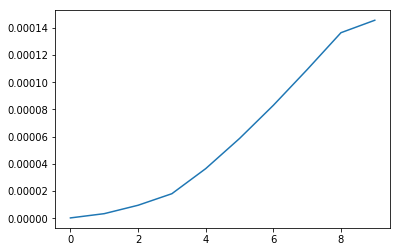

In [9]:
pyplot.plot((d[1:].mean(1)/zcbs[:d.size(0)-1]-1).data.numpy())

We can also do this for forward prices, e.g. for the 10-year ZCB in the future.

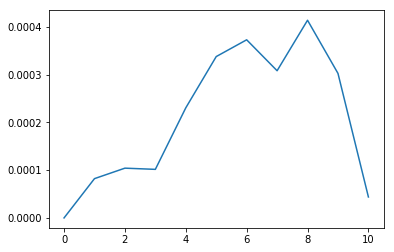

In [10]:
pyplot.plot((((model2.zcb_price(r,10)*d).mean(1)/zcbs[9:])-1).data.numpy())

We can also compare the Monte Carlo price, i.e. the discounted payoff, of a call option on a ZCB with the analytical price function.

In [11]:
def compare_zcb_call(term, tenor, strike):
  formula_price = model2.call_zcb(term, tenor, wrap(strike), wrap(0.0))
  zcb_forward   = model2.zcb_price(r[:term+1], tenor).data.numpy()[term]
  d_term = d[term,:].data.numpy()
  mc_price = (numpy.fmax(zcb_forward-strike,0)*d_term).mean()
  return formula_price.data[0], mc_price

compare_zcb_call(5,1,0.9)

(0.09214147244611484, 0.092169449862495617)

And we can also compare Monte Carlo price of a receiver swaption to the Jamshidian-calculated price.

In [12]:
def compare_swaption(term, tenor):
  atm_swap_rate = (model2.xzcbs[term]-model2.xzcbs[term+tenor])/model2.xzcbs[term+1:term+tenor+1].sum()
  zcb_forwards = torch.stack([model2.zcb_price(r[:term+1], t)[term] for t in range(1,tenor+1)])
  payoffs = (atm_swap_rate*zcb_forwards.sum(0)-(1-zcb_forwards[-1])).data.numpy()
  d_term = d[term,:].data.numpy()
  mc_price = (numpy.fmax(payoffs,0)*d_term).mean()
  formula_price,_ = model2.call_atm_swap(term, tenor)
  return mc_price, formula_price.data[0]
compare_swaption(10,10)

(0.073441667132462349, 0.0735625476327573)

# Calibration

For illustration, we calibrate the model three times.

The first method is gradient descent (which is not stochastic in our case) using the `torch.SGD` class.

In [13]:
vol_market = 0.0074 # 10-10 swaption 2016-12-31, normal volatility (=74bps)

sigma = wrap(0.016, requires_grad=True)
opt = torch.optim.SGD([sigma],lr=1e-4)
for i in range(20):
    opt.zero_grad()
    hw = ShiftedModel(Vasicek0(alpha, sigma), zcbs)
    _,vol_model = hw.call_atm_swap(10, 10)
    error = ((vol_model-vol_market)*100)**2
    error.backward()
    opt.step()
hw = ShiftedModel(Vasicek0(alpha, sigma), zcbs)
_,vol_model = hw.call_atm_swap(10, 10)
error = ((vol_model-vol_market)*100)**2
print ("err", error.data[0], "sigma", sigma.data[0])


err 4.073408922898773e-11 sigma 0.017275957440965186


The second method is the [LBFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) quasi-newton method. It is a bit more elaborate to use in pytorch because it needs a closure to reevaluate the model.

In [14]:
vol_market = 0.0074 # 10-10 swaption 2016-12-31

sigma = wrap(0.016, requires_grad=True)
opt = torch.optim.LBFGS([sigma], lr=1e-1, max_iter=100)
def calc_error():
    opt.zero_grad()
    hw = ShiftedModel(Vasicek0(alpha, sigma), zcbs)
    _,vol_model = hw.call_atm_swap(10, 10)
    error = ((vol_model-vol_market)*100)**2
    error.backward()
    return error
    
opt.step(calc_error)
opt.zero_grad()
hw = ShiftedModel(Vasicek0(alpha, sigma), zcbs)
_,vol_model = hw.call_atm_swap(10, 10)
error = ((vol_model-vol_market)*100)**2
print ("err", error.data[0], "sigma", sigma.data[0])


err 6.1346504079490504e-09 sigma 0.017277943162396


Finally, given that there is only one parameter, we implement a bisection method. The search range of $\sigma$ does seem to come out of thin air. In my experience and for $\alpha=0.1$ most historic values of $\sigma$ fall into the interval $[0.1,0.2]$, so we double each of the bounds to be safe.

In [15]:
sigma_min = 0.005
sigma_max = 0.04

vol_market = 0.0074 # 10-10 swaption 2016-12-31

_, vol_min = ShiftedModel(Vasicek0(alpha, wrap(sigma_min)), zcbs).call_atm_swap(10, 10)
_, vol_max = ShiftedModel(Vasicek0(alpha, wrap(sigma_max)), zcbs).call_atm_swap(10, 10)


while sigma_max-sigma_min>1e-6:
    sigma_mid = 0.5*(sigma_min+sigma_max)
    _, vol_mid = ShiftedModel(Vasicek0(alpha, wrap(sigma_mid)), zcbs).call_atm_swap(10, 10)
    if vol_mid.data[0] > vol_market:
        sigma_max, vol_max = sigma_mid, vol_mid
    else:
        sigma_min, vol_min = sigma_mid, vol_mid

print ("resulting sigma:",sigma_mid, "model vol:", vol_mid.data[0], "market vol:",vol_market)

resulting sigma: 0.01727638244628906 model vol: 0.007400117474390436 market vol: 0.0074


I hope this notebook is informative for you. I read and appreciate every mail with feedback you send to <tv@interestingrates.de>.

Thomas Viehmann